In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_fourier_z = pd.read_csv(os.path.join(folder_path, "features_fourier_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_fourier_mm = pd.read_csv(os.path.join(folder_path, "features_fourier_all_minmax.csv"))

In [7]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_z_cl= df_fourier_z.drop(columns=['filename', 'label'])

se va a buscar el que podría ser el mejor numero de clusteres usando BIC (Bayesian Information Criterion) y AIC (Akaike Information Criterion)

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

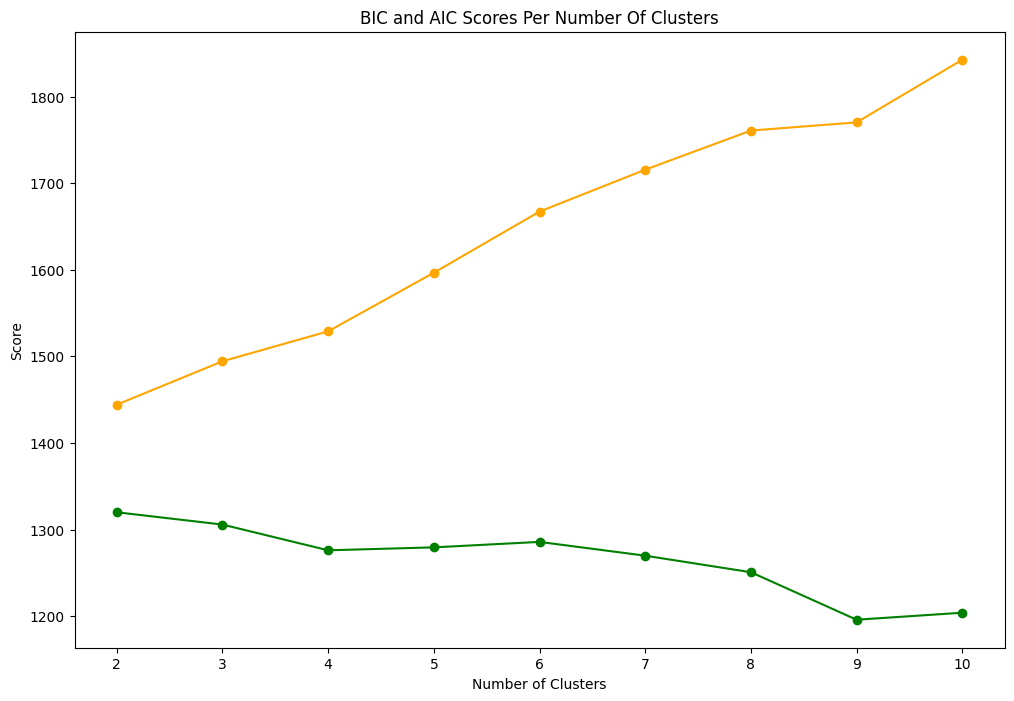

In [8]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_fourier_z_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_fourier_z_cl))
    aic_score.append(gm.aic(df_fourier_z_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')



El mejor número de clusters según AIC es probablemente 9, porque el AIC alcanza su valor mínimo allí.

El BIC, sin embargo, sugiere que el modelo con 2 clusters ya era suficientemente bueno

In [ ]:
n_components = 2  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_z = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

for cov_type, gmm_model in gmm_models_z.items():
    gmm_model.fit(df_fourier_z_cl)

In [10]:
covariances_z = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models_z.items()}

In [11]:
predictions_z = {cov_type: gmm_model.predict(df_fourier_z_cl)
               for cov_type, gmm_model in gmm_models_z.items()}

Covariance Matrix (full - Component):
[[0.29750223 0.25314983 0.29818223 0.30440482]
 [0.25314983 0.38585368 0.24228038 0.2689078 ]
 [0.29818223 0.24228038 0.32566139 0.32327015]
 [0.30440482 0.2689078  0.32327015 0.33440316]]
Covariance Matrix (tied - Component):
[0.42341912 0.24234289 0.43037496 0.43361456]
Covariance Matrix (diag - Component):
[0.23804268 0.37767481 0.24148886 0.24667998]
Covariance Matrix (spherical - Component):
0.43551651807509095


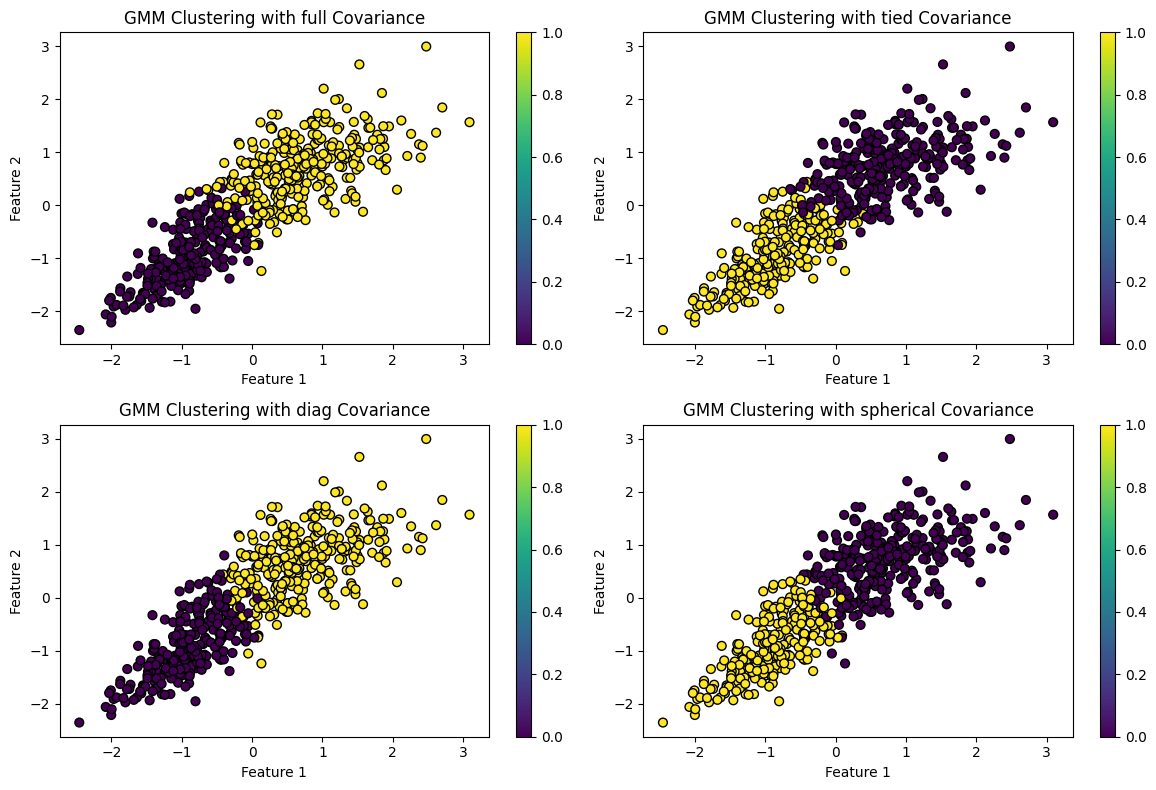

In [13]:
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(df_fourier_z_cl.iloc[:, 0], df_fourier_z_cl.iloc[:, 1], c=predictions_z[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances_z[cov_type][0]}')

plt.tight_layout()
plt.show()

In [14]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_fourier_z_cl, predictions_z[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.490
Tied covariance: Silhouette Score = 0.488
Diag covariance: Silhouette Score = 0.528
Spherical covariance: Silhouette Score = 0.527


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


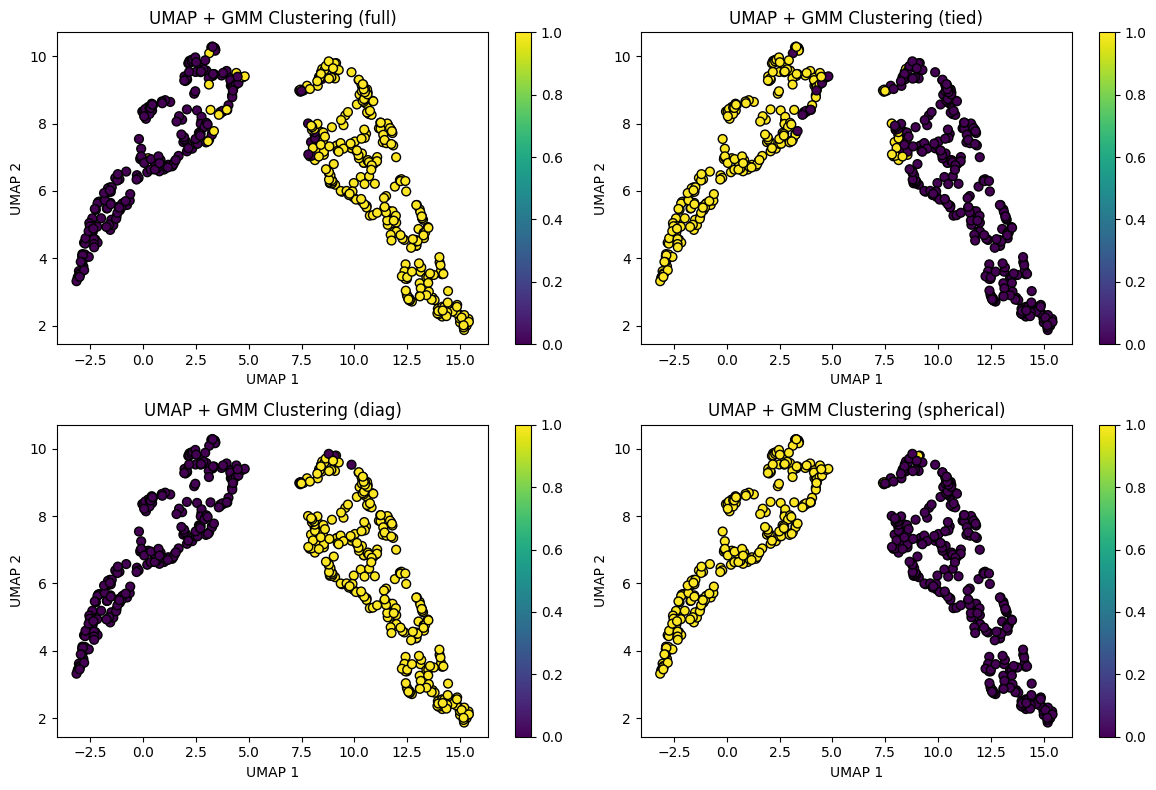

In [17]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_fourier_z_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], 
                c=predictions_z[cov_type], 
                cmap='viridis', edgecolors='k', s=40)
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

plt.tight_layout()
plt.show()




minmax

In [18]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_mm_cl= df_fourier_mm.drop(columns=['filename', 'label'])

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

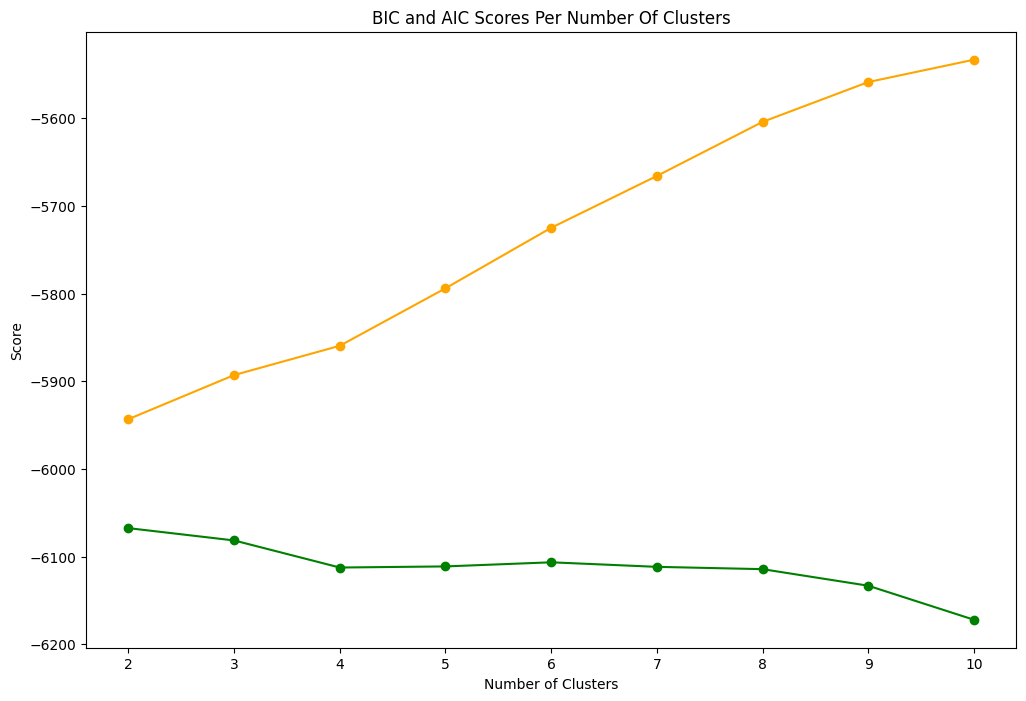

In [19]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_fourier_mm_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_fourier_mm_cl))
    aic_score.append(gm.aic(df_fourier_mm_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In [20]:
n_components = 2  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_mm = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

for cov_type, gmm_model in gmm_models_mm.items():
    gmm_model.fit(df_fourier_mm_cl)


In [21]:
covariances_mm = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models_mm.items()}

In [22]:
predictions_mm = {cov_type: gmm_model.predict(df_fourier_mm_cl)
               for cov_type, gmm_model in gmm_models_mm.items()}

Covariance Matrix (full - Component):
[[0.00975124 0.0085928  0.01019073 0.00900084]
 [0.0085928  0.01355702 0.00857741 0.00823163]
 [0.01019073 0.00857741 0.01160322 0.00996697]
 [0.00900084 0.00823163 0.00996697 0.00892024]]
Covariance Matrix (tied - Component):
[0.01375263 0.00816556 0.01456919 0.01270392]
Covariance Matrix (diag - Component):
[0.00775033 0.01324966 0.00854088 0.00653401]
Covariance Matrix (spherical - Component):
0.008829172536810473


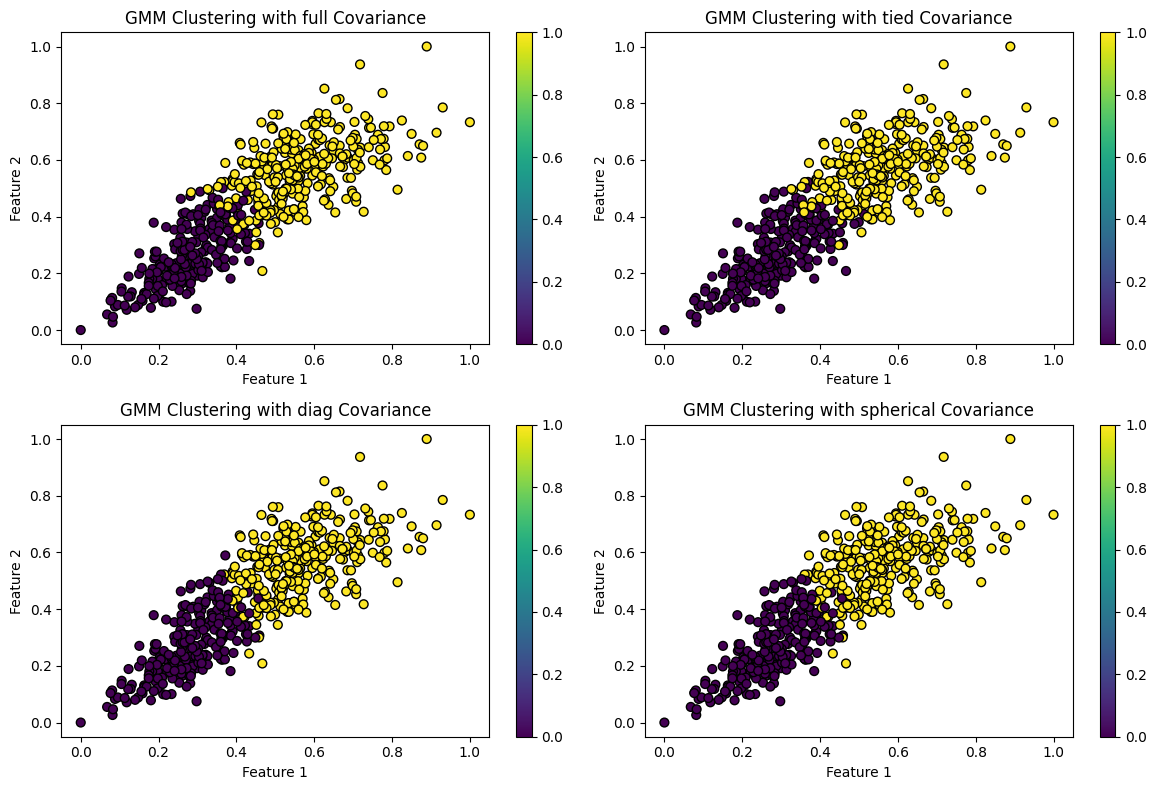

In [23]:
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(df_fourier_mm_cl.iloc[:, 0], df_fourier_mm_cl.iloc[:, 1], c=predictions_mm[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances_mm[cov_type][0]}')

plt.tight_layout()
plt.show()

In [24]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_fourier_mm_cl, predictions_mm[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.490
Tied covariance: Silhouette Score = 0.490
Diag covariance: Silhouette Score = 0.527
Spherical covariance: Silhouette Score = 0.527


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


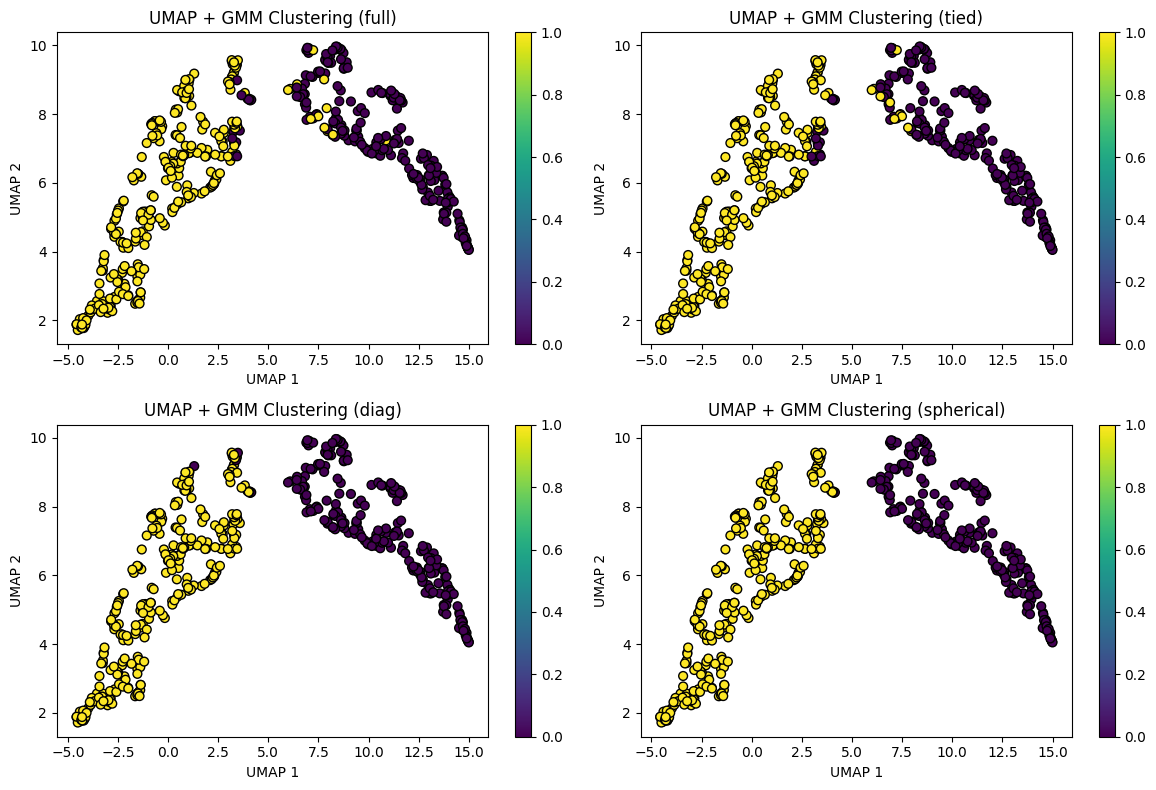

In [25]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_fourier_mm_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], 
                c=predictions_mm[cov_type], 
                cmap='viridis', edgecolors='k', s=40)
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

plt.tight_layout()
plt.show()
